# A comparison of expected 10k cohort thrombolysis rates across hospitals: subgroup analysis

## Plain English summary

We may predict the use of thrombolysis across hospitals if all hospital saw the same 10 thousand patients. We can also look at groups of those patients, representing 'ideal' thrombolysis candidates, milder strokes, strokes without a precisely known stroke onset time, or with existing pre-stroke disability. 

Almost all stroke units show high expected thrombolysis in a set of 'ideal' thrombolysis patients, but vary in expected use in subgroups with low stroke severity, no precise onset time, or existing pre-stroke disability. If a stroke unit showed lower  thombolysis in one of these subgroups they also tended to show lower thrombolysis rates in the other subgroups - suggesting a shared caution in use of thrombolysis in 'less ideal' patients.

## Model and data

An XGBoost model is trained on all but a 10k patient cohort, to predict which patient will recieve thrombolysis.The 10k patient cohort is then used in two ways: 1) as the test set for the model fitting process 2) as a common set of patients that are sent to each hospital in turn to obtain a thrombolysis rate that is comparable across hospitals which has any patient factors removed.

The XGBoost model is fitted to all but 10k instances, and uses 10 features: 

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 10 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims:

* Train XGBoost model on all data except for a 10k set of patients
* Predict use of thrombolysis in the heldback 10k cohort of patients, at each of the 132 hospitals (by changing hospital one-hot coding).
* Predict use of thrombolysis in three sbgroups of patients:
  * Mild stroke severity (NIHSS < 5)
  * No precise onset time
  * Existing pre-stroke disability (mRS > 2)
  * An *ideal* thrombolysable patient:
    * Stroke severity NIHSS in range 10-25
    * Arrival-to-scan time < 30 minutes
    * Stroke type = infarction
    * Precise onset time = True
    * Prior diability level (mRS) = 0
    * No use of AF anticoagulants
    * Onset-to-arrival time < 90 minutes
    * Age < 80 years
    * Onset during sleep = False

## Observations

* The 10k cohort may be grouped to show thrombolysis in particular groups

* Those hospitals with lower thrombolysis use, compared with their total thrombolysis use, in three subsets of patients (NIHSS < 5, mRS >2, no precise onset time) tend to have signficantly lower overal thrombolysis use in the full 10k patients.

* When testing the 'ideal' thrombolysable patients, 95% of hospitals would be expected to give thrombolysis to at least 99% of patients.

* The range of thrombolysis use across hopsitals in the other subgroups was as follows:
  * All 10k patients: minimum = 10%, median = 28%, maxiumum = 45%
  * NIHSS <5: : minimum = 0%, median = 6%, maxiumum = 25%
  * No precise onset time: : minimum = 0%, median = 7%, maxiumum = 20%
  * Prestroke mRS >2: : minimum = 0%, median = 11%, maxiumum = 38%

* The three subgroups of NIHSS <5, no precise stroke onset time, and prestroke mRS > 2, showed quite high pairwise correlations (r-squared 0.45 to 0.62). The three subgorups also showed quite strong correlation with the expected thrombolysis rate across all 10k patients (r-squared 0.68 to 0.77)

* Almost all stroke units show high expected thrombolysis in a set of 'ideal' thrombolysis patients, but vary in expected use in subgroups with low stroke severity, no precise onset time, or existing pre-stroke disability. If a stroke unit showed lower  thombolysis in one of these subgroups they also tended to show lower thrombolysis rates in the other subgroups - suggesting a shared caution in use of thrombolysis in 'less ideal' patients.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import pickle
import shap

from scipy import stats

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier

from os.path import exists
import json

## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_key_features = 10
model_text = f'xgb_{number_key_features}_features'
notebook = '04'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [5]:
data_loc = '../data/10k_training_test/'

In [6]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
number_of_features_to_use = 10
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=dict_feature_name, inplace=True)
test = test[key_features]
test.rename(columns=dict_feature_name, inplace=True)

Store admissions per hospital

In [7]:
df_admissions = (
    pd.DataFrame(index=np.unique(train["Stroke team"], return_counts=True)[0]))
df_admissions[f"Admissions"] = (
    np.unique(train["Stroke team"], return_counts=True)[1])

## Fit XGBoost model

Fit XGBoost model on the 10k cohort train/test dataset, and calculate model accuracy.

Save models.

In [8]:
# Fit models (True), or load models (False)
fit_models = True

# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('Stroke team', axis=1, inplace=True)    

filename = (f'./saved_models/{notebook}_{model_text}_10k_cohort.p')

# Fit model
if fit_models:
    # Define model
    model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
    model.fit(X_train, y_train)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(model, filehandler)
else:
    # Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.848


Calculate receiver operating characteristic curve area under curve.

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print (f'ROC ACUC: {roc_auc:.3f}')

ROC ACUC: 0.915


### Pass 10k cohort through all hospital models and get thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [10]:
hospitals = list(set(train['Stroke team']))
hospitals.sort()
thrombolysis_rate = []
single_predictions = []

# For each hospital
for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
    # Save predictions
    single_predictions.append(y_pred * 1)

In [11]:
# Convert individual predictions (a list of arrays) to a NumPy array, and 
#   transpose
patient_results = np.array(single_predictions).T
# Convert to DataFrame
patient_results = pd.DataFrame(patient_results, columns=hospitals)
patient_results.to_csv(f'./predictions/{notebook}_{model_text}_10k_individual_'
                       f'predictions.csv', index=False)

## Get thrombolysis use in groups of patients

In [12]:
list (test)

['Arrival-to-scan time',
 'Infarction',
 'Stroke severity',
 'Precise onset time',
 'Prior disability level',
 'Stroke team',
 'Use of AF anticoagulants',
 'Onset-to-arrival time',
 'Onset during sleep',
 'Age',
 'Thrombolysis']

In [13]:
# All patients
results = pd.DataFrame()
results['All patients'] = patient_results.mean(axis=0) * 100

In [14]:
# 'Ideal patients'
mask = ((test['Stroke severity'] <= 25) &
        (test['Stroke severity'] >= 10) & 
        (test['Arrival-to-scan time'] <= 30) &
        (test['Infarction'] == 1) &
        (test['Precise onset time'] == 1) &
        (test['Prior disability level'] == 0) &
        (test['Use of AF anticoagulants'] == 0) &
        (test['Onset-to-arrival time'] <= 90) &
        (test['Age'] < 80) &
        (test['Onset during sleep'] == 0)
        )

included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['Ideal'] = patient_results[mask].mean(axis=0) * 100

for i in [100, 99, 95, 90, 85]:
    ans = np.sum(results['Ideal'] >= i) / len(results['Ideal']) * 100
    print (f'Percent of hopsitals giving thrombolysis to at least {i} percent patients: {ans:0.1f}')

Included patients: 290.00
Percent of hopsitals giving thrombolysis to at least 100 percent patients: 89.4
Percent of hopsitals giving thrombolysis to at least 99 percent patients: 94.7
Percent of hopsitals giving thrombolysis to at least 95 percent patients: 97.7
Percent of hopsitals giving thrombolysis to at least 90 percent patients: 97.7
Percent of hopsitals giving thrombolysis to at least 85 percent patients: 99.2


In [15]:
# Mild stroke (NIHSS < 5)
mask = test['Stroke severity'] < 5
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['NIHSS < 5'] = patient_results[mask].mean(axis=0) * 100

Included patients: 3746.00


In [16]:
# No precise onset time
mask = test['Precise onset time'] == 0
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['No precise onset'] = patient_results[mask].mean(axis=0) * 100

Included patients: 3769.00


In [17]:
# Prior disability
mask = test['Prior disability level'] > 2
included_patients = mask.sum()
print (f'Included patients: {included_patients:0.2f}')
results['mRS > 2'] = patient_results[mask].mean(axis=0) * 100

Included patients: 2028.00


Add ratios to 'ideal' patients

In [18]:
results['NIHSS < 5 norm'] = results['NIHSS < 5'] / results['Ideal']
results['No precise onset norm'] = results['No precise onset'] / results['Ideal']
results['mRS > 2 norm'] = results['mRS > 2'] / results['Ideal']

Show hospitals with low thrombolysis in mild stroke (compared with their own overall thrombolysis use).

In [19]:
results.sort_values('NIHSS < 5 norm', ascending=True).head(10)

,All patients,Ideal,NIHSS < 5,No precise onset,mRS > 2,NIHSS < 5 norm,No precise onset norm,mRS > 2 norm
LGNPK4211W,14.45,96.896552,0.000000,0.716370,5.177515,0.000000,0.007393,0.053433
HZMLX7970T,11.49,87.241379,0.026695,1.193951,1.873767,0.000306,0.013686,0.021478
OUXUZ1084Q,12.95,99.310345,0.053390,0.610241,0.147929,0.000538,0.006145,0.001490
WJHSV5358P,22.39,100.000000,0.080085,7.720881,7.248521,0.000801,0.077209,0.072485
HYCCK3082L,16.41,100.000000,0.240256,2.387901,3.550296,0.002403,0.023879,0.035503
IATJE0497S,20.34,100.000000,0.266951,0.106129,8.629191,0.002670,0.001061,0.086292
LFPMM4706C,17.16,100.000000,0.320342,2.918546,5.424063,0.003203,0.029185,0.054241
LECHF1024T,14.78,85.172414,0.507208,3.900239,2.761341,0.005955,0.045792,0.032421
XQAGA4299B,23.14,99.655172,0.774159,4.616609,9.319527,0.007768,0.046326,0.093518
IUMNL9626U,20.58,100.000000,0.880940,5.624834,15.088757,0.008809,0.056248,0.150888


Show hospitals with high thrombolysis in mild stroke (compared with their own overall thrombolysis use).

In [20]:
results.sort_values('NIHSS < 5 norm', ascending=False).head(10)

,All patients,Ideal,NIHSS < 5,No precise onset,mRS > 2,NIHSS < 5 norm,No precise onset norm,mRS > 2 norm
TPXYE0168D,39.62,100.0,25.280299,6.102414,23.422091,0.252803,0.061024,0.234221
CNBGF2713O,40.93,100.0,22.423919,17.962324,27.465483,0.224239,0.179623,0.274655
HPWIF9956L,41.31,100.0,21.783235,12.549748,29.881657,0.217832,0.125497,0.298817
VKKDD9172T,45.27,100.0,21.623065,18.333776,38.412229,0.216231,0.183338,0.384122
GKONI0110I,41.32,100.0,18.579818,19.793049,24.506903,0.185798,0.197930,0.245069
HBFCN1575G,38.11,100.0,18.419648,11.753781,26.972387,0.184196,0.117538,0.269724
NTPQZ0829K,39.23,100.0,16.871329,19.872645,21.548323,0.168713,0.198726,0.215483
QWKRA8499D,38.82,100.0,15.776829,19.554258,25.394477,0.157768,0.195543,0.253945
MHMYL4920B,38.94,100.0,15.616658,18.599098,25.197239,0.156167,0.185991,0.251972
XDAFB7350M,38.67,100.0,14.548852,19.978774,24.161736,0.145489,0.199788,0.241617


Show hospitals with low thrombolysis with no precise onset time (compared with their own overall thrombolysis use).

In [21]:
results.sort_values('No precise onset', ascending=True).head(10)

,All patients,Ideal,NIHSS < 5,No precise onset,mRS > 2,NIHSS < 5 norm,No precise onset norm,mRS > 2 norm
IATJE0497S,20.34,100.000000,0.266951,0.106129,8.629191,0.002670,0.001061,0.086292
HZNVT9936G,32.06,100.000000,9.930593,0.451048,27.071006,0.099306,0.004510,0.270710
JADBS8258F,24.64,100.000000,5.552589,0.477580,8.579882,0.055526,0.004776,0.085799
OUXUZ1084Q,12.95,99.310345,0.053390,0.610241,0.147929,0.000538,0.006145,0.001490
LGNPK4211W,14.45,96.896552,0.000000,0.716370,5.177515,0.000000,0.007393,0.053433
HYNBH3271L,21.24,100.000000,3.737320,0.875564,4.930966,0.037373,0.008756,0.049310
LZAYM7611L,19.05,99.655172,1.788574,1.140886,7.199211,0.017948,0.011448,0.072241
HZMLX7970T,11.49,87.241379,0.026695,1.193951,1.873767,0.000306,0.013686,0.021478
TFSJP6914B,23.76,100.000000,5.659370,1.193951,7.692308,0.056594,0.011940,0.076923
IYJHY1440E,20.55,100.000000,2.269087,1.273547,5.621302,0.022691,0.012735,0.056213


Show hospitals with high thrombolysis with no precise onset time (compaerd with their own overall thrombolysis use).

In [22]:
results.sort_values('No precise onset', ascending=False).head(10)

,All patients,Ideal,NIHSS < 5,No precise onset,mRS > 2,NIHSS < 5 norm,No precise onset norm,mRS > 2 norm
XDAFB7350M,38.67,100.0,14.548852,19.978774,24.161736,0.145489,0.199788,0.241617
NTPQZ0829K,39.23,100.0,16.871329,19.872645,21.548323,0.168713,0.198726,0.215483
GKONI0110I,41.32,100.0,18.579818,19.793049,24.506903,0.185798,0.197930,0.245069
SMVTP6284P,36.34,100.0,7.848372,19.739984,27.958580,0.078484,0.197400,0.279586
QWKRA8499D,38.82,100.0,15.776829,19.554258,25.394477,0.157768,0.195543,0.253945
MHMYL4920B,38.94,100.0,15.616658,18.599098,25.197239,0.156167,0.185991,0.251972
VKKDD9172T,45.27,100.0,21.623065,18.333776,38.412229,0.216231,0.183338,0.384122
IAZKG9244A,37.57,100.0,12.146289,18.333776,26.873767,0.121463,0.183338,0.268738
XKAWN3771U,36.13,100.0,12.306460,18.121518,14.003945,0.123065,0.181215,0.140039
CNBGF2713O,40.93,100.0,22.423919,17.962324,27.465483,0.224239,0.179623,0.274655


Show hospitals with low thrombolysis with pre-existing disabilty (compared with their own overall thrombolysis use).

In [23]:
results.sort_values('mRS > 2', ascending=True).head(10)

,All patients,Ideal,NIHSS < 5,No precise onset,mRS > 2,NIHSS < 5 norm,No precise onset norm,mRS > 2 norm
OUXUZ1084Q,12.95,99.310345,0.053390,0.610241,0.147929,0.000538,0.006145,0.001490
HZMLX7970T,11.49,87.241379,0.026695,1.193951,1.873767,0.000306,0.013686,0.021478
TKRKH4920C,21.09,97.931034,1.788574,3.024675,1.923077,0.018264,0.030886,0.019637
LECHF1024T,14.78,85.172414,0.507208,3.900239,2.761341,0.005955,0.045792,0.032421
YEXCH8391J,20.94,100.000000,1.815270,7.216768,2.859961,0.018153,0.072168,0.028600
BICAW1125K,21.50,100.000000,4.458089,3.687981,3.007890,0.044581,0.036880,0.030079
NZNML2841Q,22.64,100.000000,5.579285,2.785885,3.057199,0.055793,0.027859,0.030572
HYCCK3082L,16.41,100.000000,0.240256,2.387901,3.550296,0.002403,0.023879,0.035503
FAJKD7118X,24.31,100.000000,3.683930,11.382330,3.944773,0.036839,0.113823,0.039448
NFBUF0424E,23.64,100.000000,5.125467,3.953303,3.994083,0.051255,0.039533,0.039941


Show hospitals with high thrombolysis with pre-existing disabilty (compaerd with their own overall thrombolysis use).

In [24]:
results.sort_values('mRS > 2', ascending=False).head(10)

,All patients,Ideal,NIHSS < 5,No precise onset,mRS > 2,NIHSS < 5 norm,No precise onset norm,mRS > 2 norm
VKKDD9172T,45.27,100.0,21.623065,18.333776,38.412229,0.216231,0.183338,0.384122
HPWIF9956L,41.31,100.0,21.783235,12.549748,29.881657,0.217832,0.125497,0.298817
QQUVD2066Z,36.73,100.0,8.702616,14.804988,28.895464,0.087026,0.148050,0.288955
SMVTP6284P,36.34,100.0,7.848372,19.739984,27.958580,0.078484,0.197400,0.279586
CNBGF2713O,40.93,100.0,22.423919,17.962324,27.465483,0.224239,0.179623,0.274655
HZNVT9936G,32.06,100.0,9.930593,0.451048,27.071006,0.099306,0.004510,0.270710
HBFCN1575G,38.11,100.0,18.419648,11.753781,26.972387,0.184196,0.117538,0.269724
IAZKG9244A,37.57,100.0,12.146289,18.333776,26.873767,0.121463,0.183338,0.268738
QWKRA8499D,38.82,100.0,15.776829,19.554258,25.394477,0.157768,0.195543,0.253945
MHMYL4920B,38.94,100.0,15.616658,18.599098,25.197239,0.156167,0.185991,0.251972


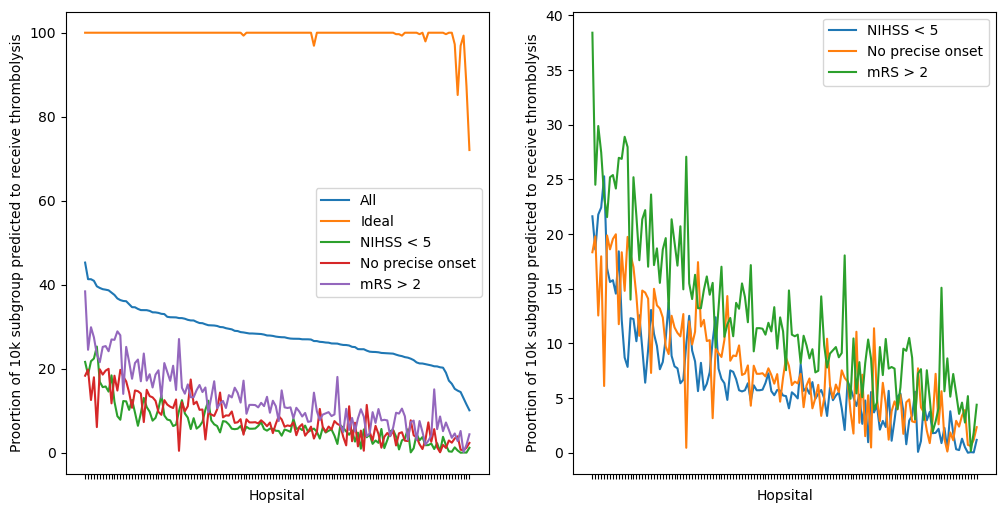

In [25]:
sorted_results = results.sort_values('All patients', ascending=False)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.plot(sorted_results['All patients'], label = 'All')
ax1.plot(sorted_results['Ideal'], label = 'Ideal')
ax1.plot(sorted_results['NIHSS < 5'], label = 'NIHSS < 5')
ax1.plot(sorted_results['No precise onset'], label = 'No precise onset')
ax1.plot(sorted_results['mRS > 2'], label = 'mRS > 2')
ax1.set_xticklabels([])
ax1.legend()
ax1.set_xlabel('Hopsital')
ax1.set_ylabel('Proortion of 10k subgroup predicted to receive thrombolysis')

ax2 = fig.add_subplot(122)
ax2.plot(sorted_results['NIHSS < 5'], label = 'NIHSS < 5')
ax2.plot(sorted_results['No precise onset'], label = 'No precise onset')
ax2.plot(sorted_results['mRS > 2'], label = 'mRS > 2')
ax2.set_xticklabels([])
ax2.legend()
ax2.set_xlabel('Hopsital')
ax2.set_ylabel('Proortion of 10k subgroup predicted to receive thrombolysis')

plt.show()

## Show a summary of results

In [26]:
results.describe()


,All patients,Ideal,NIHSS < 5,No precise onset,mRS > 2,NIHSS < 5 norm,No precise onset norm,mRS > 2 norm
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,27.963636,99.469697,6.607452,7.915853,12.598246,0.066142,0.079321,0.126252
std,6.330286,2.974083,4.802008,5.047863,7.096859,0.047961,0.050326,0.070732
min,10.100000,72.068966,0.000000,0.106129,0.147929,0.000000,0.001061,0.001490
25%,23.995000,100.000000,3.810731,4.119130,7.692308,0.038206,0.041589,0.076923
50%,27.605000,100.000000,5.672718,7.123906,10.798817,0.056727,0.071239,0.107988
75%,32.052500,100.000000,7.948478,10.984346,16.161243,0.079485,0.109843,0.161612
max,45.270000,100.000000,25.280299,19.978774,38.412229,0.252803,0.199788,0.384122


## Check correlations between 10k subgroups

In [27]:
pairs_to_test = [
    ['All patients', 'NIHSS < 5'],
    ['All patients', 'No precise onset'],
    ['All patients', 'mRS > 2'],
    ['NIHSS < 5', 'No precise onset'],
    ['NIHSS < 5', 'mRS > 2'],
    ['No precise onset', 'mRS > 2']]

for pair in pairs_to_test:
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(results[pair[0]],results[pair[1]])
    print (f'Correlation between {pair[0]} and {pair[1]}:'
           f'\n  r-squared = {r_value**2:0.3f}, p = {p_value:0.3f}\n')

Correlation between All patients and NIHSS < 5:
  r-squared = 0.766, p = 0.000

Correlation between All patients and No precise onset:
  r-squared = 0.679, p = 0.000

Correlation between All patients and mRS > 2:
  r-squared = 0.774, p = 0.000

Correlation between NIHSS < 5 and No precise onset:
  r-squared = 0.445, p = 0.000

Correlation between NIHSS < 5 and mRS > 2:
  r-squared = 0.621, p = 0.000

Correlation between No precise onset and mRS > 2:
  r-squared = 0.528, p = 0.000



## Save results

In [28]:
results.to_csv('./output/15_10k_groups.csv', index=True)